<a href="https://colab.research.google.com/github/itsdawei/qsc-airplane/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Create a shortcut of the shared drive, and run this cell to mount the shared drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/MyDrive/"Quant SC Airlines Fall '22"

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1JiYK74Y2YXRe6RuIEM2TLs061hgjdI8f/Quant SC Airlines Fall '22


In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Make plots in jupyter larger (https://stackoverflow.com/a/36368116)
plt.rcParams['figure.dpi'] = 100

Read the delay data provided by Bureau of Transportation Statistics.

We preprocess the data by filtering for the following
- A specific list of airlines that we want to analyze.
- A specific time frame that we want to analyze (July 1, 2011 to Oct 1, 2022.)

In [ ]:
# Import delay data.
import pandas as pd
all_delay_data = pd.read_csv("Bureau of Transportation Statistics Data/Airline_Delay_Cause.csv")

ticket_airline_map = {
    "UAL": "UA",
    "SKYW": "OO",
    "SAVE": "NK",
    "LUV": "WN",
    "JBLU": "B6",
    "HA": "HA",
    "DAL": "DL",
    "ALK": "AS",
    "ALGT": "G4",
    "AAL": "AA",
}

# Filtering based on airline.
delay_data = all_delay_data[all_delay_data["carrier"].isin(ticket_airline_map.values())]

# Convert "year" and "month" column to date.
delay_data.loc[:,"date"] = pd.to_datetime(delay_data[["year", "month"]].assign(day=1))

# Drop.
delay_data.drop(["year", "month", "carrier_name", "airport", "airport_name"], axis=1, inplace=True)

delay_data = delay_data.rename(columns={"carrier": "airline"})

# Filter by date; July 1, 2011 to Oct 1, 2022.
delay_data = delay_data[delay_data["date"].between("2011-07-01", "2022-10-01")]

delay_data = delay_data.groupby(["airline", "date"]).sum()
delay_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


arr_flights  arr_del15  carrier_ct  weather_ct   nas_ct  \
airline date                                                                  
AA      2011-07-01      47249.0     9407.0     3579.51      461.31  2517.63   
        2011-08-01      46911.0     9489.0     3439.42      576.89  2676.60   
        2011-09-01      43560.0     7181.0     2602.88      326.84  2393.19   
        2011-10-01      44463.0     7110.0     2583.19      205.53  2504.03   
        2011-11-01      41465.0     7229.0     2378.18      179.85  3000.71   

                    security_ct  late_aircraft_ct  arr_cancelled  \
airline date                                                       
AA      2011-07-01         2.60           2845.90          991.0   
        2011-08-01         5.78           2790.38         1601.0   
        2011-09-01         5.19           1852.91          359.0   
        2011-10-01         5.43           1811.83          269.0   
        2011-11-01         0.06           1670.17          190.0   

                    arr_diverted  arr_delay  carrier_delay  weather_delay  \
airline date                                                                
AA      2011-07-01         165.0   551073.0       217472.0        33186.0   
        2011-08-01         196.0   568416.0       212797.0        39991.0   
        2011-09-01         195.0   405992.0       162362.0        25865.0   
        2011-10-01         116.0   357684.0       150430.0        14731.0   
        2011-11-01          68.0   355581.0       138402.0         9308.0   

                    nas_delay  security_delay  late_aircraft_delay  
airline date                                                        
AA      2011-07-01   113442.0            56.0             186917.0  
        2011-08-01   126111.0           446.0             189071.0  
        2011-09-01    99038.0           165.0             118562.0  
        2011-10-01    89891.0           196.0             102436.0  
        2011-11-01   113127.0             2.0              94742.0

Read the stock data for the airlines.

We preprocess the data by filtering for the following
- A specific list of airlines that we want to analyze.
- A specific time frame that we want to analyze (July 1, 2011 to Oct 1, 2022.)

In [ ]:
stock_data = pd.read_csv("Yahoo Airlines Data/MASTER MONTHLY.csv")
stock_data.columns = stock_data.columns.str.strip()
stock_data = stock_data.rename(columns={"Date": "date"})

stock_data["date"] = pd.to_datetime(stock_data["date"])

# Filter by date; July 1, 2011 to Oct 1, 2022.
stock_data = stock_data[stock_data["date"].between("2011-07-01", "2022-10-01")]

stock_data = stock_data.set_index("date")
stock_data = stock_data.rename(columns = ticket_airline_map)

## Visualizing the Dataset
Let's first plot the flight volume data for each airline.

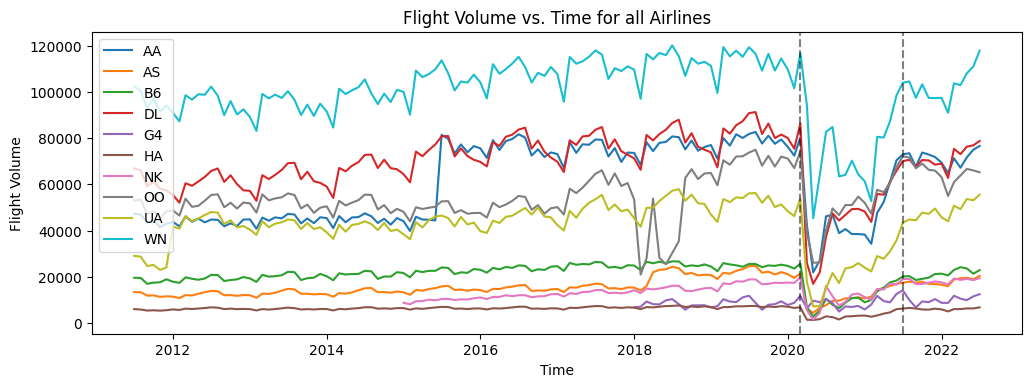

In [ ]:
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(12,4))

a = delay_data["arr_flights"].unstack(level=0)
plt.plot(a)

plt.legend(a.columns)
plt.xlabel("Time")
plt.ylabel("Flight Volume")
plt.title("Flight Volume vs. Time for all Airlines")

plt.axvline(pd.to_datetime("2020-03-01"), linestyle = '--', color = 'k', alpha = 0.5)
plt.axvline(pd.to_datetime("2021-07-01"), linestyle = '--', color = 'k', alpha = 0.5)

plt.show()

Notice that:
- All airlines experiences a drop in volumne around the start of 2020 due to COVID-19.
- OO experiences a drop in volume on 2018-02, 2018-04.
- AA experiences a spike in volume near 2016

Apart from the anomities the in the data, we see that each year of data follows the same pattern, implying seasonality.

We might as well also plot the stock prices of each airline over time.

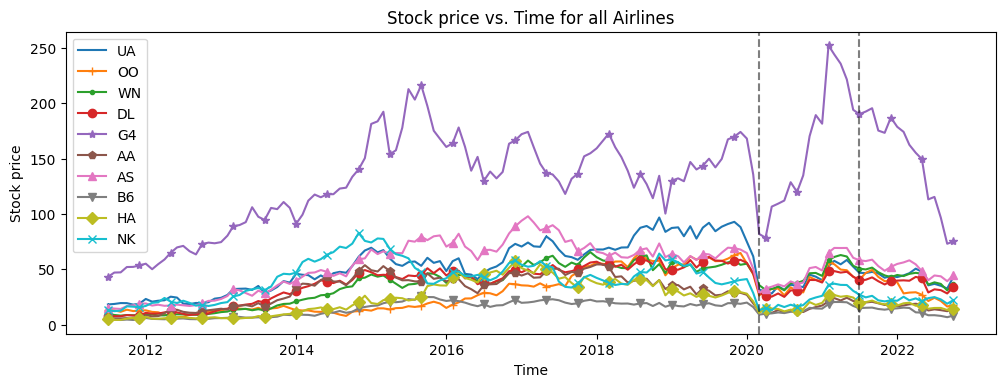

In [ ]:
import itertools

marker = itertools.cycle((",", "+", ".", "o", "*", "p", "^", "v", "D", "x")) 
plt.figure(figsize=(12,4))

for airline in stock_data.columns:
  plt.plot(stock_data[airline], marker=next(marker), markevery=5)

plt.legend(stock_data.columns)
plt.xlabel("Time")
plt.ylabel("Stock price")
plt.title("Stock price vs. Time for all Airlines")

plt.axvline(pd.to_datetime("2020-03-01"), linestyle = '--', color = 'k', alpha = 0.5)
plt.axvline(pd.to_datetime("2021-07-01"), linestyle = '--', color = 'k', alpha = 0.5)

plt.show()

We can also visualize the correlation of the stock prices with other variables from flight delay dataset for each airline.

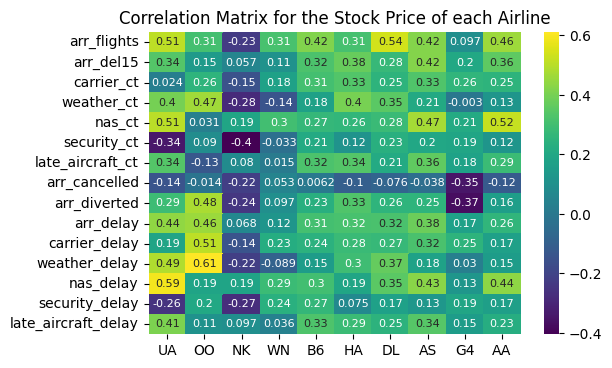

In [ ]:
corr_list = []

for i, airline in enumerate(ticket_airline_map.values()):
  delay_stock = delay_data.loc[airline]
  delay_stock[airline] = stock_data[airline]

  corr = delay_stock.corr()
  corr_list.append(corr.iloc[:-1][airline])

corr_matrix = pd.concat(corr_list, axis=1)

plt.title("Correlation Matrix for the Stock Price of each Airline")
sns.heatmap(corr_matrix, annot=True, cmap="viridis", annot_kws={"size":8})

plt.show()

## Principle Component Analysis (PCA)

We first try to figure out how many principle components are significant in our data by visualizing the amount of variance explained by **all** of the components.

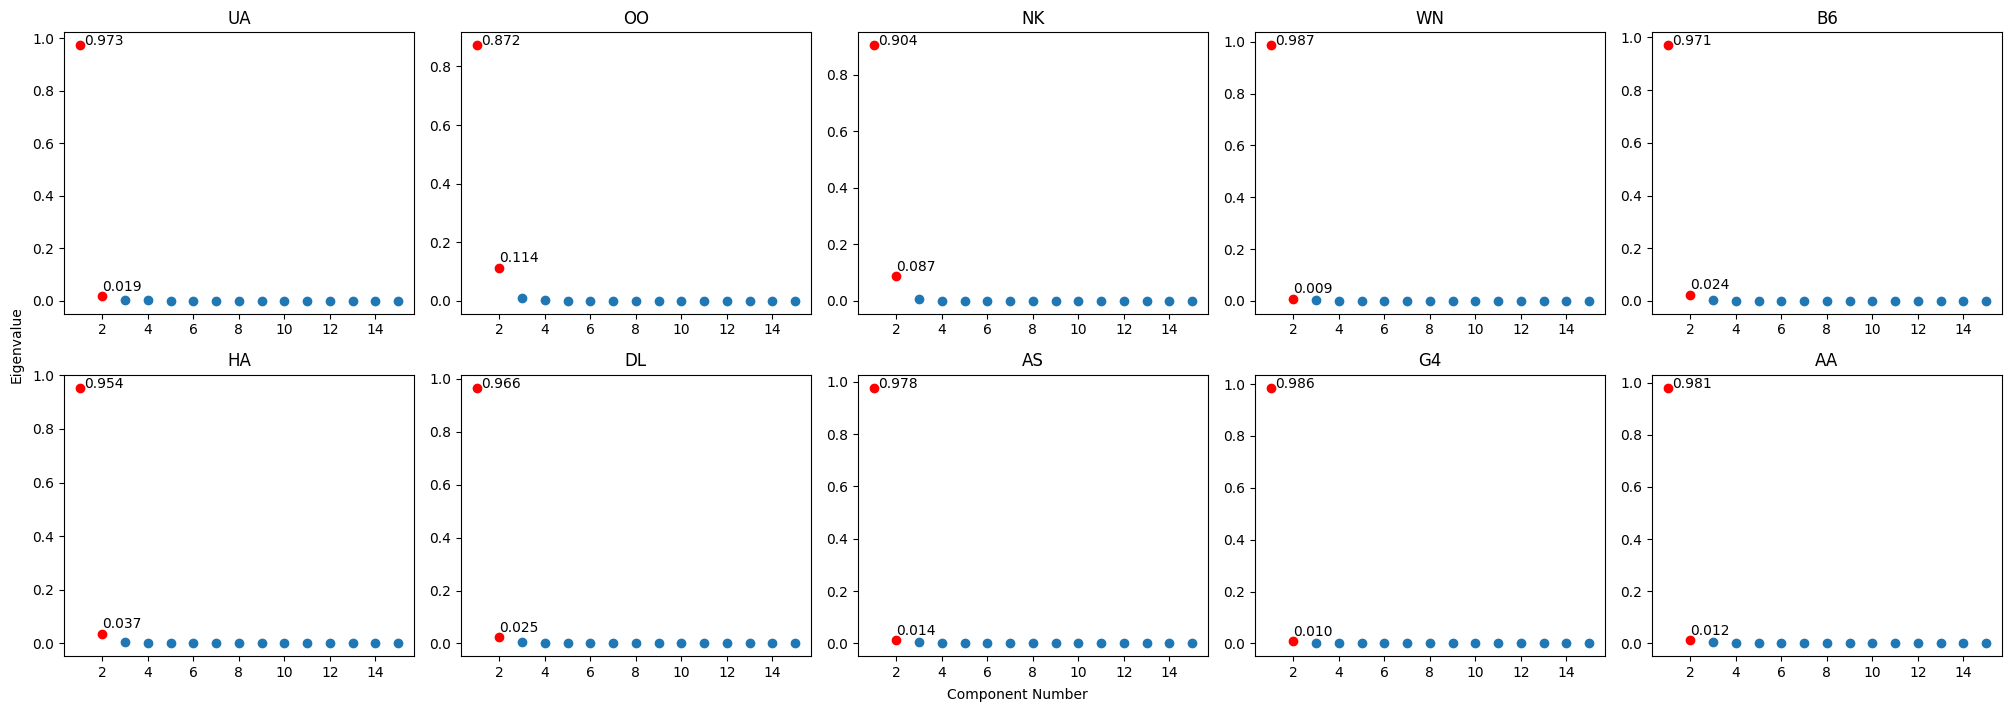

In [ ]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA

features = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
            'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
            'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
            'security_delay', 'late_aircraft_delay']

nrow = 2
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(20,7))

for i, airline in enumerate(ticket_airline_map.values()):
  ax = axs[i // ncol][i % ncol]

  # Use all the variables.
  pca = PCA(n_components=None)
  _ = pca.fit(delay_data.loc[airline, features])

  y = pca.explained_variance_ratio_
  x = np.linspace(1, len(y), len(y))

  # Plot the top two components in red.
  ax.plot(x[:2], y[:2], "ro")
  ax.plot(x[2:], y[2:], "o")

  # Annotate first and second point.
  ax.annotate(f"{y[0]:.3f}", (x[0] + 0.2, y[0]))
  ax.annotate(f"{y[1]:.3f}", (x[1], y[1] + 0.02))

  ax.set_xlabel("")
  ax.set_ylabel("")
  ax.set_title(airline)

fig.tight_layout()
fig.text(0.5, 0, "Component Number", ha="center", va="center")
fig.text(0, 0.5, "Eigenvalue", ha="center", va="center", rotation="vertical")

plt.show()

We see that for most airlines (except OO and NK), the first PCA components explains $> 95\%$ of the variance. **For all airlines, the first two PCA components explains $> 95\%$ of the variance.**

Therefore, we will re-run the PCA assuming two principle components.

We keep track of the transformed data for each airline in `df_pca_dict`.

In [ ]:
df_pca_dict = dict()

for i, airline in enumerate(ticket_airline_map.values()):
  ax = axs[i // ncol][i % ncol]
  airline_data = delay_data.loc[airline, features]

  n_components=2
  pca = KernelPCA(n_components=n_components, gamma=10, alpha=0.1)
  transformed_data = pca.fit_transform(airline_data)

  df_pca = pd.DataFrame(data = transformed_data, columns=[f"PCA_{i}" for i in range(n_components)], index = airline_data.index)
  df_pca["stock"] = stock_data[airline]
  df_pca_dict[airline] = df_pca

## Time Series Correlation Check

In [ ]:
from sklearn.feature_selection import r_regression

# Use Pearson correlation coefficient to check for correlation.
for airline in ticket_airline_map.values():
  pca_projection = df_pca_dict[airline]

  x = pca_projection.iloc[:,:-1]
  y = pca_projection.iloc[:,-1:].to_numpy()
  correlation = r_regression(x, np.ravel(y))
  print(f"The correlation coefficient for each PCA component of {airline} is {correlation}.")

The correlation coefficient for each PCA component of UA is [0.43980457 0.48911477].
The correlation coefficient for each PCA component of OO is [0.46011929 0.26929948].
The correlation coefficient for each PCA component of NK is [0.08041712 0.20344301].
The correlation coefficient for each PCA component of WN is [0.11492561 0.46315901].
The correlation coefficient for each PCA component of B6 is [ 0.30989467 -0.10262928].
The correlation coefficient for each PCA component of HA is [0.31329626 0.01065368].
The correlation coefficient for each PCA component of DL is [ 0.31673305 -0.06920185].
The correlation coefficient for each PCA component of AS is [ 0.38337713 -0.20741277].
The correlation coefficient for each PCA component of G4 is [ 0.17321586 -0.17756748].
The correlation coefficient for each PCA component of AA is [ 0.25755476 -0.4008316 ].


In [ ]:
models = {}
for airline in ticket_airline_map.values():
  df_pca = df_pca_dict[airline]

  model = VAR(df_pca)
  models[airline] = model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

In [ ]:
model.select_order(maxlags=12).summary()

,AIC,BIC,FPE,HQIC
0,52.25,52.31,4.898e+22,52.27
1,48.06*,48.33*,7.428e+20*,48.17*
2,48.10,48.58,7.722e+20,48.29
3,48.13,48.83,8.034e+20,48.42
4,48.19,49.09,8.480e+20,48.55
5,48.24,49.35,8.945e+20,48.69
6,48.33,49.65,9.862e+20,48.87
7,48.32,49.85,9.807e+20,48.94
8,48.40,50.13,1.063e+21,49.10
9,48.48,50.42,1.158e+21,49.26


In [ ]:
models["AA"].fit(1).summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Nov, 2022
Time:                     01:32:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    48.1275
Nobs:                     132.000    HQIC:                   47.9720
Log likelihood:          -3709.02    FPE:                6.13386e+20
AIC:                      47.8655    Det(Omega_mle):     5.60840e+20
--------------------------------------------------------------------
Results for equation PCA_0
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const       -64516.830494     53143.659839           -1.214           0.225
L1.PCA_0         0.805392         0.056135           14.347           0.000
L1.PCA_1         0.624520         0.534864            1.168           0.243
L1.s

In [ ]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def fit_model(x, y, algo="lasso", l1_ratio=0.5, max_iter=2000):
  if algo == "lasso":
    # Lasso (Elastic Net with l1ratio=1) uses l1 norm, so minimizes the number of features (model gets penalized more for using a small amount of another feature, good for multicollinearity)
    regr = Lasso(max_iter=max_iter, selection="random")
  elif algo == "ridge":
    # Ridge l2 norm, so minimizes to total amount of features (harder to interpret, also not penalized for using a small amount of another feature)
    regr = Ridge(max_iter=max_iter)
  elif algo == "elastic_net":
    # Elastic net trades off Lasso and Ridge (l1ratio * Lasso + (1 - l1ratio) * Ridge)
    regr = ElasticNet(l1_ratio=l1_ratio, max_iter=max_iter, selection="random")
  pipeline = make_pipeline(StandardScaler(with_mean=False), regr)
  pipeline.fit(x, y)

  return pipeline

In [ ]:
# On original data.
x = delay_data.loc["UA"]
y = stock_data.loc[x.index, "UA"]

# Split Data
split = int(x.shape[0] * 0.8)
x_train, x_test = x.iloc[:split], x.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

lasso_score = fit_model(x_train, y_train, algo="lasso").score(x_test, y_test)
ridge_score = fit_model(x_train, y_train, algo="ridge").score(x_test, y_test)
elastic_score = fit_model(x_train, y_train, algo="elastic_net").score(x_test, y_test)

print(lasso_score, ridge_score, elastic_score)

-4.66268319203355 -4.1895359210308545 -2.0996805503638747


In [ ]:
from statsmodels.tsa.stattools import adfuller
X = delay_data.loc["UA"]["arr_flights"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.427733
p-value: 0.134061
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


# Going to try to make the data stationary

Source: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/VAR%20Model.ipynb

In [ ]:
from datetime import datetime

def stationarize(original_data, visualize=False, visualize_features=None):
  # Standardize.
  standardize = original_data.apply(lambda col: (col - col.mean()) / col.std(), axis=0)

  # Take difference.
  diff = standardize.diff().dropna()
  # Remove volatility.
  annual_volatility = diff.groupby(diff.index.year).std()

  annual_volatility.loc[2023] = annual_volatility.loc[2022]
  annual_volatility.index = pd.to_datetime(annual_volatility.index, format='%Y')

  annual_volatility = annual_volatility.resample("MS").ffill().loc[diff.index]

  volatile = diff / annual_volatility

  # Detrend.
  month_avgs = volatile.groupby(volatile.index.month).mean()

  detrended = pd.DataFrame()
  for col_name in volatile.columns:
    detrended[col_name] = volatile[col_name] - volatile.index.map(lambda d: month_avgs.loc[d.month, col_name])

  # rolling_mean = volatile.rolling(window = 12).mean()
  # detrended = volatile - rolling_mean

  if visualize:
    nrow = 5
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol, figsize=(20,15))

    if visualize_features is None:
      visualize_features = original_data.columns

    axs[0].plot(original_data[visualize_features])
    axs[0].set_title("Original")
    for year in range(2011, 2022):
      axs[0].axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)

    axs[1].plot(standardize[visualize_features])
    axs[1].set_title("Standardize")
    for year in range(2011, 2022):
      axs[1].axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)
    
    axs[2].plot(diff[visualize_features])
    axs[2].set_title("Difference")
    for year in range(2011, 2022):
      axs[2].axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)

    axs[3].plot(volatile[visualize_features])
    axs[3].set_title("Remove Volatility")
    for year in range(2011, 2022):
      axs[3].axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)


    axs[4].plot(detrended[visualize_features])
    axs[4].set_title("Remove Trend")
    for year in range(2011, 2022):
      plt.axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)

    plt.legend(visualize_features)
    plt.show()

  return detrended

In [ ]:
def stationarize(column, visualize=False, visualize_features=None):
  standardize = (column - column.mean()) / column.std()

  diff = standardize.diff().dropna().diff().dropna()
  if (visualize):
    nrow = 2
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol, figsize=(20,15))
    if visualize_features is None:
      visualize_features = original_data.columns

    axs[0].plot(original_data[visualize_features])
    axs[0].set_title("Original")
    for year in range(2011, 2022):
      axs[0].axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)
    
    axs[1].plot(diff[visualize_features])
    axs[1].set_title("Double Difference")
    for year in range(2011, 2022):
      plt.axvline(datetime(year, 1, 1), linestyle = '--', color = 'k', alpha = 0.5)

    plt.legend(visualize_features)
    plt.show()
  return diff

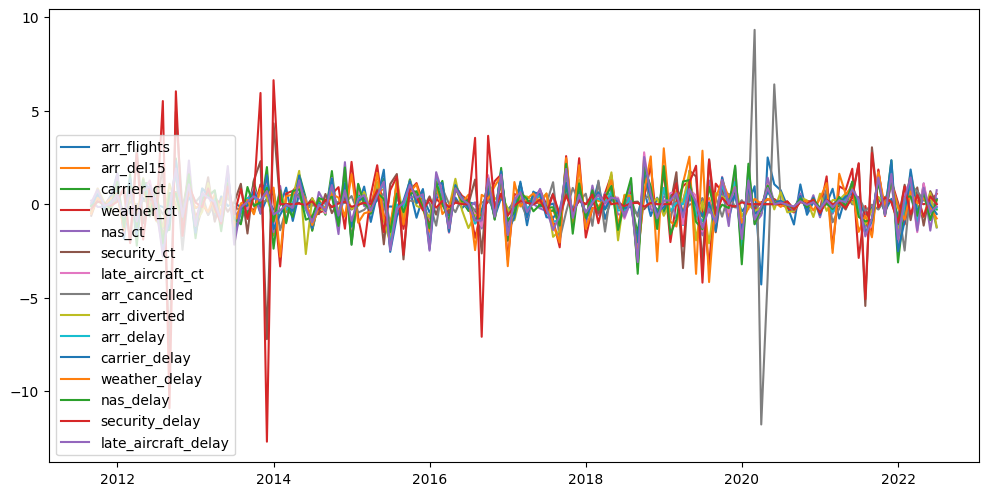

In [ ]:
station_data = delay_data.groupby("airline").apply(lambda x: stationarize(x.droplevel(0)))

plt.figure(figsize=(12,6))
plt.plot(station_data.loc["UA"][features])
plt.legend(station_data.columns)
plt.show()

Testing that our data is actually stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(station_data["arr_flights"].dropna().values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.821700
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


## Remove COVID Period



In [ ]:
def remove_period(data, start="2020-03-01", end="2021-07-01", visualize=False):
  original = data
  splice = data.loc[start:end]

  if visualize:
    plt.figure(figsize=(12,6))
    plt.plot(original)

    plt.plot(splice)
    plt.axvline(pd.to_datetime("2020-03-01"), linestyle = '--', color = 'k', alpha = 0.5)
    plt.axvline(pd.to_datetime("2021-07-01"), linestyle = '--', color = 'k', alpha = 0.5)

    plt.title("Time Splice effected by COVID-19 (WN)")
    plt.show()
  
  c1 = data.index.get_level_values("date") < start
  c2 = data.index.get_level_values("date") >= end

  return data[c1 | c2]

In [ ]:
station_no_covid = remove_period(station_data)

# plt.figure(figsize=(12,6))
# plt.plot(station_no_covid.loc["UA"][features])
# plt.legend(features)
# plt.show()

In [ ]:
no_covid = remove_period(delay_data)
no_covid_station = no_covid.groupby("airline").apply(lambda x: stationarize(x.droplevel(0)))

# plt.figure(figsize=(12,6))
# plt.plot(no_covid_station.loc["UA"][features])
# plt.legend(no_covid_station.columns)
# plt.show()

## Predictions

In [ ]:
from sklearn.svm import SVR

In [ ]:
def VAR_predict(x_train, y_train, exp_name, lags=13, steps=12, visualize=False):
  forecasts = []
  
  for airline, df in x_train.groupby(level=0):
    xx = x_train.loc[airline]
    yy = y_train[airline]

    train_input = pd.concat([xx, yy], axis=1).dropna()
    model = VAR(train_input)
    model_fit = model.fit(maxlags=lags)

    test_input = pd.concat([xx, yy], axis=1).dropna()
    lagged_values = test_input.iloc[-lags:]
    forecast = model_fit.forecast(lagged_values.values, steps=steps) 

    idx = pd.date_range(lagged_values.index[-1], periods=steps, freq='MS')
    df_forecast=pd.DataFrame(data=forecast[:, 3], index=idx, columns=[airline])

    forecasts.append(df_forecast)

  predictions = pd.concat(forecasts, axis=1)
  predictions.to_csv(f"Figures/{exp_name}.csv")

  nrow = 3
  ncol = 3
  fig, axs = plt.subplots(nrow, ncol, figsize=(20,7))

  for i, airline in enumerate(predictions.columns):
    ax = axs[i // ncol][i % ncol]

    # Use all the variables.
    ax.plot(stock_data[airline])
    ax.plot(predictions[airline])

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(airline)

  fig.tight_layout()
  fig.text(0.5, 0, "Time", ha="center", va="center")
  fig.text(0, 0.5, "Stock Price", ha="center", va="center", rotation="vertical")
  fig.savefig(f"Figures/{exp_name}.png")
  if not visualize:
    plt.close()

In [ ]:
# Split Data
# features = ["arr_flights", "carrier_ct", "security_ct", "arr_cancelled", "arr_diverted", "weather_delay", "nas_delay"]
features = ["arr_flights", "carrier_ct", "nas_delay"]

# x = station_data[station_data.index.get_level_values("date") < "2019-03-01"][features]
x = station_data[features]
y = stock_data

# Drop G4
x = x.drop( "G4")

x_train, x_test = x, x
y_train, y_test = y, y

# Stationary vs. Stock price (forward).
VAR_predict(x_train, y_train, exp_name="station_vs_stock_forward")

# Stationary vs. Stock price (backward, split).
x = station_data[station_data.index.get_level_values("date") < "2019-03-01"][features]
x = x.drop( "G4")

x_train, x_test = x, x
print(x_train)
VAR_predict(x_train, y_train, exp_name="station_vs_stock_backward_split")

                    arr_flights  carrier_ct  nas_delay
airline date                                          
AA      2011-09-01    -0.181314   -0.485037  -0.523525
        2011-10-01     0.255995    0.568889   0.236141
        2011-11-01    -0.234752   -0.129065   0.426584
        2011-12-01     0.265864    0.351474  -0.736797
        2012-01-01    -0.034542   -0.477356   0.476576
...                         ...         ...        ...
WN      2018-10-01     1.166746    1.463892   1.564347
        2018-11-01    -0.727197   -0.108514   0.010073
        2018-12-01     0.232732    0.283117   0.117930
        2019-01-01    -0.180758   -1.620978  -0.083133
        2019-02-01    -0.724828    1.848538   0.636304

[768 rows x 3 columns]


In [ ]:
features = ["arr_flights", "carrier_ct", "nas_delay"]

x = no_covid_station[features]
y = stock_data

# Drop G4
x = x.drop("G4")

x_train, x_test = x, x
y_train, y_test = y, y

# No-Covid Stationary vs. Stock price (forward).
VAR_predict(x_train, y_train, exp_name="nc_station_vs_stock_forward")

# No-Covid Stationary vs. Stock price (backward, split).
x = no_covid_station[no_covid_station.index.get_level_values("date") < "2019-03-01"][features]
x = x.drop( "G4")

x_train, x_test = x, x
print(x_train)
VAR_predict(x_train, y_train, exp_name="nc_station_vs_stock_backward_split")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

                    arr_flights  carrier_ct  nas_delay
airline date                                          
AA      2011-09-01    -0.191291   -0.542153  -0.561664
        2011-10-01     0.270080    0.635879   0.253344
        2011-11-01    -0.247669   -0.144263   0.457661
        2011-12-01     0.280492    0.392862  -0.790473
        2012-01-01    -0.036442   -0.533567   0.511295
...                         ...         ...        ...
WN      2018-10-01     1.831323    1.713329   1.858220
        2018-11-01    -1.141408   -0.127004   0.011965
        2018-12-01     0.365296    0.331358   0.140084
        2019-01-01    -0.283718   -1.897181  -0.098751
        2019-02-01    -1.137689    2.163515   0.755838

[768 rows x 3 columns]


In [ ]:
# Lasso, Ridge, and Elastic Net on no-covid-stationary data.
lasso_score = fit_model(x_train, y_train, algo="lasso").score(x_test, y_test)
ridge_score = fit_model(x_train, y_train, algo="ridge").score(x_test, y_test)
elastic_score = fit_model(x_train, y_train, algo="elastic_net").score(x_test, y_test)

print(lasso_score, ridge_score, elastic_score)

NameError: ignored

In [ ]:
# VAR on no-covid-stationary data.
input = pd.concat([no_covid_station, stock_station], axis=1).dropna()
model = VAR(input)
print(model.select_order(13).summary())

model_fit = model.fit(maxlags=2)
model_fit.summary()

In [ ]:
# SVR-rbf on no-covid-stationary data.
regr = SVR(kernel="rbf", C=1, epsilon=0.1)
regr.fit(x_train, y_train)

regr.score(x_test, y_test)

-0.11896956834546102

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

base = SVR(kernel="rbf", C=1, epsilon=0.1)
# base = None
regr = AdaBoostRegressor(base_estimator=base, n_estimators=100, learning_rate=1)
regr.fit(x_train, y_train)

regr.score(x_test, y_test)

-0.32463923577176623



---



In [ ]:
# Lasso, Ridge, and Elastic Net on stationary data.
x = station_data
y = stock_station.loc[x.index, "UA"]

# Split Data
split = int(x.shape[0] * 0.8)
x_train, x_test = x.iloc[:split], x.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

lasso_score = fit_model(x_train, y_train, algo="lasso").score(x_test, y_test)
ridge_score = fit_model(x_train, y_train, algo="ridge").score(x_test, y_test)
elastic_score = fit_model(x_train, y_train, algo="elastic_net", l1_ratio=0.5).score(x_test, y_test)

print(lasso_score, ridge_score, elastic_score)

-0.0003787222427116266 -0.09796575675606078 -0.0003787222427116266


In [ ]:
from sklearn.svm import SVR

# SVR-rbf on stationary data.
regr = SVR(kernel="rbf", C=1, epsilon=0.1)
regr.fit(x, y)

regr.score(x, y)

0.2280560253187338

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

base = SVR(kernel="rbf", C=1, epsilon=0.1)
# base = None
regr = AdaBoostRegressor(base_estimator=base, n_estimators=200)
regr.fit(x_train, y_train)

regr.score(x_test, y_test)

-0.2294516453457669

In [ ]:
# # VAR on station data
# input = pd.concat([station_data, stock_station], axis=1).dropna()
# model = VAR(input)
# model_fit = model.fit(maxlags=1)
# model_fit.summary()

NotImplementedError: ignored